## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on untrained data.
- Maintain good code quality.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

In [2]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False)

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


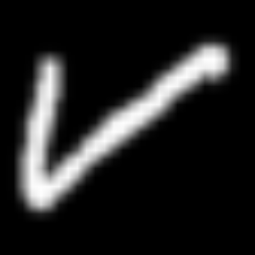

In [3]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

In [4]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transform)
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.2 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

Training subset size: 139586
Test subset size: 23264


## Defaining the Neural Network model

In [16]:
num_epochs = 10
lr = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
train_losses = []
val_losses = []

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, stride=1, padding=0),
    nn.Tanh(),
    # output size = (in - kernal_size + 2*padding) / stride + 1
    #output size = 28-5+1 = 24
    nn.MaxPool2d(kernel_size=2, stride=2),
    #output size = 24/2 = 12
    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0),
    nn.Tanh(),
    #output size = 12-5+1 = 8

    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
    nn.Flatten(), 
    nn.Linear(64*3*3, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 62),  
    nn.LogSoftmax(dim=1) 
)

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')


optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class


Using device cuda


The training loop

In [17]:
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)  # convert to [N, 28*28] shape where N is batch_size
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)    # add loss for tracking. we'll visualize the loss trajectory later


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss:.3f}, val_loss={val_epoch_loss:.3f}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

Epoch: 0, train_loss=0.9061031351457236, val_loss=0.528. labelled 19275.000/23264 correctly (82.85333562585969% accuracy)
Epoch: 1, train_loss=0.47841380024175706, val_loss=0.461. labelled 19543.000/23264 correctly (84.00533012379643% accuracy)
Epoch: 2, train_loss=0.423712954418543, val_loss=0.424. labelled 19777.000/23264 correctly (85.01117606602476% accuracy)
Epoch: 3, train_loss=0.3929408666539035, val_loss=0.419. labelled 19709.000/23264 correctly (84.71887895460797% accuracy)
Epoch: 4, train_loss=0.3716304457540534, val_loss=0.406. labelled 19849.000/23264 correctly (85.32066712517194% accuracy)
Epoch: 5, train_loss=0.35408802363096153, val_loss=0.407. labelled 19727.000/23264 correctly (84.79625171939477% accuracy)
Epoch: 6, train_loss=0.3392602835990293, val_loss=0.399. labelled 19907.000/23264 correctly (85.56997936726273% accuracy)
Epoch: 7, train_loss=0.3247436764096243, val_loss=0.401. labelled 19857.000/23264 correctly (85.35505502063275% accuracy)
Epoch: 8, train_loss=0.

Visualization for the model loss over epochs

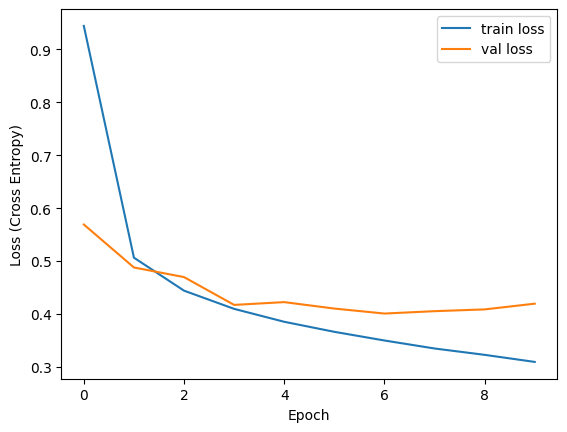

In [11]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

Validation

In [8]:
model.eval()
correctly_labelled = 0
with torch.no_grad():

  val_epoch_weighted_loss = 0

  for val_batch_X, val_batch_y in test_loader:
    val_batch_X = val_batch_X.to(device)
    val_batch_y = val_batch_y.to(device)

    val_batch_y_probs = model(val_batch_X)

    loss = criterion(val_batch_y_probs, val_batch_y)
    val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

    val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob   

    correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
val_losses.append(val_epoch_loss)

print(f'val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')


val_loss=0.40865796726540327. labelled 19855/23264 correctly (85.34645804676754% accuracy)
